In [1]:
import numpy as np
import itertools
import os

In [2]:
# IMPORTANT: MAKE SURE TO USE THE `parthenon-frontend` BRANCH FROM 
# https://github.com/forrestglines/yt/tree/parthenon-frontend

import yt
#yt.enable_parallelism()

yt.set_log_level(50)

yt : [ERROR    ] 2023-01-30 12:08:17,831 Could not enable parallelism: only one mpi process is running. To remedy this, launch the Python interpreter as
  mpirun -n <X> python3 <yourscript>.py  # with X > 1 


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [4]:
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 11

matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Physics of Plasmas figure sizes
OneColWidth = 3.37
TwoColWidth = 6.69


In [5]:
mpl.rcParams["figure.facecolor"]="white"

In [6]:
#sim_dir = "/scratch/cvz/glines/magnetized-clusters/cluster_testing/feedback_suite/large.all_mechs"
cooling_table_filename = "/u/glines/code/magnetized-clusters/inputs/cooling_tables/schure.cooling"

## Define and set specifications for statistics

Defines a "statistic" to read over time from a simulation, including what field to examine, what aspects (min, max, total, median, etc.) to read from the field, how to treat nans, how to weigh means, how to mask data

In [7]:

class FieldStatsSpec:
    """
    StatisticSpec
    
    Defines a "statistic" to read over time from a simulation,
    including what field to examine, what aspects (min, max, total, median, etc.)
    to read from the field, how to treat nans, how to weigh means, how to mask data
    
    """
    def __init__(self,
                 field, #Field to integrate
                 statistics, #Which statistics (total, min, max, mean)
                 stats_label=None,
                 derived_field_name=None,
                 weighting_func=None, #Function accepting (field,data) returning weighted field
                 masking_func=None, #Function accepting (field,data) returning masked field
                 yt_field_units=None,
                 nan_policy="ignore",
                 mean_weighting_field=None,
                 ):
        
        self.field = field
        self.statistics = tuple(statistics)

        
        self.need_derived_field = ( weighting_func is not None\
                                 or masking_func is not None\
                                 or nan_policy is not "ignore")
        
        self.weighting_func = weighting_func
        self.masking_func = masking_func
        
        if self.need_derived_field and derived_field_name is None:
            if stats_label is None:
                my_hash = hash((self.field,self.statistics,weighting_func,masking_func))
                derived_field_name = f"fss_{field}_{my_hash}"
            else:
                derived_field_name = f"fss_{stats_label}"
                
        self.yt_field_units = yt_field_units
        if self.need_derived_field and self.yt_field_units is None:
            raise Exception("Need to provide yt_field_units if derived_field is needed")

            
        #Name given to yt derived field used to generate data
        self.derived_field_name=derived_field_name
        
        if self.need_derived_field:
            self.yt_field_name = self.derived_field_name
        else:
            self.yt_field_name = field
                
        if stats_label is None:
            if derived_field_name is None:
                stats_label =  field
            else:
                stats_label = derived_field_name
        self.stats_label = stats_label
        
        self.nan_policy = nan_policy
        
        self.mean_weighting_field = mean_weighting_field
        
    def add_derived_fields_to_ds(self,ds):
        if self.need_derived_field:
            def derived_field_func(field,data,fss=self):
                out = data[fss.field]
                if fss.weighting_func is not None:
                    out = fss.weighting_func(out,data)
                if fss.masking_func is not None:
                    out = fss.masking_func(out,data)
                    
                if fss.nan_policy is "zero":
                    out[np.isnan(out)] = 0
                elif fss.nan_policy is "mask":
                    out = out[ np.logical_not(np.isnan(out)) ]
                    
                return out
                
            derived_field_func.__name__ = self.derived_field_name

            ds.add_field(("gas",self.derived_field_name), 
                function= derived_field_func,
                sampling_type="local",units=self.yt_field_units)


# cell_volume weighting funciton: Useful for integrating cell-averaged quantities
def cell_volume_weighting_func(field_to_weight,data):
    return field_to_weight*data["cell_volume"]

# cold_temp masking function: Best for computing the total mass of "cold" gas,
# where the "cold" temperature threshold can be specified
def cold_temp_masking_func(field_to_mask,data,temp_thresh):
    mask = np.where(data["temperature"].in_units("K")>temp_thresh.in_units("K"))
    field_to_mask[mask ]=0
    return field_to_mask
        
cold_mass_thresh_strs=["1e4","4e4","1e5","4e7"]

# Create a list of statistics to read
field_stats_specs = [
    #Here starts the list for unmasked quantities
    FieldStatsSpec("density",["mean","min","max"],mean_weighting_field="cell_volume"),
    FieldStatsSpec("pressure",["mean","min","max"],mean_weighting_field="cell_mass"),
    FieldStatsSpec("temperature",["mean","min","max"],mean_weighting_field="cell_mass"),
    FieldStatsSpec("cooling_rate",["mean","min","max"],mean_weighting_field="cell_mass"),
    FieldStatsSpec("cooling_time",["mean","min","max"],mean_weighting_field="cell_mass"),
    FieldStatsSpec("cooling_rate",["total"],stats_label="cell_cooling_rate",
                   weighting_func=cell_volume_weighting_func,yt_field_units="erg/s"),
    FieldStatsSpec("cooling_rate",["total"],stats_label="cell_cooling_rate",
               weighting_func=cell_volume_weighting_func,yt_field_units="erg/s"),
] + [
    #Here starts the list for cold temperature masked mass statistics,
    #one for each cold temperature threshold
    FieldStatsSpec("density",["total"],stats_label=f"cell_cold_mass_t<={temp_thresh}K",
               weighting_func=cell_volume_weighting_func,
               masking_func= lambda field_to_mask,data,temp_thresh=temp_thresh:
                   cold_temp_masking_func(field_to_mask,data,
                   temp_thresh=yt.YTQuantity(float(temp_thresh),"K")),
               yt_field_units="code_mass")
    for temp_thresh in cold_mass_thresh_strs
]


#Convert that list into a dictionary

#How to index
#field_stats_specs[fss.stats_label]

field_stats_specs = { fss.stats_label: fss for fss in field_stats_specs}



<>:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:73: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:75: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:73: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:75: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_2369271/3776858473.py:28: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  or nan_policy is not "ignore")
/tmp/ipykernel_2369271/3776858473.py:73: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if fss.nan_policy is "zero":
/tmp/ipykernel_2369271/3776858473.py:75: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif fss.nan_policy is "mask":


## Operations for reading/saving/loading Stats Data

Functions to read, save, and load the statistics defined above from a single simulation directory

In [8]:
def read_all_field_stats(sim_dir):
    """
    Read statistics from the primitive outputs in sim_dir and return them in an all_field_stats object
    """
    outputs_glob = f"{sim_dir}/parthenon.restart.*.rhdf"
    
    #Create a time series to read from 
    ts = yt.load(outputs_glob,parameters={
        "cooling_table_filename":cooling_table_filename,
        "cooling_table_log_temp_col":0,
        "cooling_table_log_lambda_col":1,
        "cooling_table_lambda_units_cgs":1})

    times = yt.YTArray([ds.current_time for ds in ts]).in_units("Myr")

    # Define an empty storage dictionary for collecting information
    # in parallel through processing
    storage = {}

    #Process in parallel the datasets from the globbed time series
    #(is this feasible for large datasets? to hold all slices on one processor?)
    for sto, ds in ts.piter(storage=storage):

        ds_field_stats = {stats_label:{} for stats_label in field_stats_specs.keys()}

        reg = ds.all_data()

        for fss in field_stats_specs.values():
            fss.add_derived_fields_to_ds(ds)
            for stat in fss.statistics:
                if stat == "min":
                    ds_field_stats[fss.stats_label]["min"]=reg[fss.yt_field_name].min()
                elif stat == "max":
                    ds_field_stats[fss.stats_label]["max"]=reg[fss.yt_field_name].max()
                elif stat == "mean":
                    ds_field_stats[fss.stats_label]["mean"]=reg.quantities.weighted_average_quantity(
                        fss.yt_field_name,fss.mean_weighting_field)
                elif stat == "total":
                    ds_field_stats[fss.stats_label]["total"]=reg.quantities.total_quantity(fss.yt_field_name)

        sto.result = {"ds_field_stats":ds_field_stats}
        sto.result_id = str(ds)
    
    storage_items = sorted(storage.items())
    
    #all_field_stats[stats_label][stat][output_idx]
    all_field_stats = {stats_label:{ 
            stat:yt.YTArray([ value["ds_field_stats"][stats_label][stat] for key,value in storage_items ])
        for stat in fss.statistics } for stats_label,fss in field_stats_specs.items()}
    
    all_field_stats["times"] = times
    
    return all_field_stats
def save_all_field_stats(all_field_stats,save_dir):
    fake_ds = {"current_time": yt.YTQuantity(0, "Myr")} # To appease cosmology units dependent on time in yt
    
    save_name = f"{save_dir}/all_field_stats.h5"
    
    my_data = { f"{stats_label}:{stat}":all_field_stats[stats_label][stat].in_base("cgs")
               for stats_label,fss in field_stats_specs.items() 
               for stat in fss.statistics }
    
    my_data["times"] = all_field_stats["times"].in_base("cgs")
    
    return yt.save_as_dataset(fake_ds,save_name,my_data)

def load_all_field_stats(filename):
    ds = yt.load(filename)
    
    all_field_stats  = { stats_label:{ stat: ds.data[f"{stats_label}:{stat}"] 
                                      for stat in fss.statistics } 
                        for stats_label,fss in field_stats_specs.items()}
    all_field_stats["times"] = ds.data["times"]
    return all_field_stats

def HACK_truncate_last_output(in_stats):
    out_stats  = { stats_label:{ stat: in_stats[stats_label][stat][:-1]
                                      for stat in fss.statistics } 
                        for stats_label,fss in field_stats_specs.items()}
    out_stats["times"] = out_stats["times"][:-1]
    return out_stats

In [9]:
## Create lists of different simulations to plot

### Suite of AGN feedback mechanisms

These simulations should now work as expected

In [16]:
#feedback_mesh_sizes = ["tiny","small","medium","large"]#,"huge"

feedback_mesh_sizes = ["small",]
feedback_mechs = ["thermal","magnetic","kinetic"]

feedback_sim_names = [ f"{mesh_size}.{feedback_mech}" 
                      for mesh_size in feedback_mesh_sizes
                      for feedback_mech in 
                          ["all_mechs",] 
                        + [f"no_{mech}"for mech in feedback_mechs]
                        + feedback_mechs]
feedback_sim_labels = feedback_sim_names

feedback_testing_root = "/scratch/cvz/glines/magnetized-clusters/cluster_testing/feedback_suite"

feedback_sim_dirs = [ f"{feedback_testing_root}/{sim_name}" for sim_name in feedback_sim_names ]

In [17]:
sim_names = feedback_sim_names
sim_labels = feedback_sim_labels
sim_dirs = feedback_sim_dirs

## Read the statistics and save them to disk for each simulation in the suite
### Takes a long time!

In [18]:
%%script false --no-raise-error
#Uncomment the above line to skip this execution

for sim_name,sim_dir in zip(sim_names,sim_dirs):    
    if not os.path.exists(f"{sim_dir}/all_field_stats.h5"):
        if not os.path.exists(f"{sim_dir}/parthenon.restart.00000.rhdf"):
            print(f"Skipping stats for {sim_name}, simulation data not present or not yet run")
        else:
            print(f"Reading stats for {sim_name}")
            all_field_stats = read_all_field_stats(sim_dir)
            save_all_field_stats(all_field_stats,sim_dir)

## Functions to make history plots/figures

In [23]:
def plot_fig_suite(fig,axes,sim_names,sim_dirs,sim_labels,add_line_func):
    """
    Plots add_line_func for each simulation on different axis in a figure
    """
    
    for sim_name,sim_dir,sim_label,ax in zip(sim_names,sim_dirs,sim_labels,axes.flatten()):
        
        if not os.path.exists(f"{sim_dir}/all_field_stats.h5"):
            print(f"Skipping plotting {sim_name}")
            continue
        
        print(f"Plotting {sim_name}")
        all_field_stats  = load_all_field_stats(f"{sim_dir}/all_field_stats.h5")

        add_line_func(fig,ax,all_field_stats)
        
        ax.annotate(text=sim_label,xy=(0.05,0.95),
                    ha="left",va="top",
                    xycoords="axes fraction",fontsize=SMALL_SIZE)
        
def plot_ax_suite(fig,ax,sim_names,sim_dirs,sim_labels,add_line_func):
    """
    Plots add_line_func for each simulation on one axis
    """
    
    for sim_name,sim_dir,sim_label in zip(sim_names,sim_dirs,sim_labels):
        
        if not os.path.exists(f"{sim_dir}/all_field_stats.h5"):
            print(f"Skipping plotting {sim_name}")
            continue
        print(f"Plotting {sim_name}")
            
        all_field_stats  = load_all_field_stats(f"{sim_dir}/all_field_stats.h5")

        add_line_func(fig,ax,all_field_stats,label=sim_label)

## Make a cold mass (with different cold temperature thresholds) over time, one simulation to an axis

In [24]:
def add_cold_masses_to_ax(fig,ax,all_field_stats):
    """
    Adds the cold mass vs time to an axis from the
    all_field_stats object for each of the cold mass thresholds
    """
    cold_mass_stats_labels = [ stats_labels for stats_labels in all_field_stats.keys() 
                               if "cell_cold_mass" in stats_labels]

    cold_mass_thresh_strs=["1e4","4e4","1e5","4e7"]

    linestyle = itertools.cycle((':', '-.', '--', '-')) 

    for thresh_str in cold_mass_thresh_strs:
        stat_label = f"cell_cold_mass_t<={thresh_str}K"

        ax.plot(all_field_stats["times"].in_units("Myr"),
                all_field_stats[stat_label]["total"].in_units("msun"),
                linestyle = next(linestyle),
                label=f"T<= {thresh_str}K") 
        
fig,axes = plt.subplots(nrows=2,ncols=4,figsize=(8,5),sharex="all",sharey="all")
        

plot_fig_suite(fig,axes,sim_names,sim_dirs,sim_labels,add_cold_masses_to_ax)

axes[0,0].legend()
axes[0,0].set_yscale("log")


fig.tight_layout(rect=[0.007,0.005,1.0,1.0])

fig.text(0.5, 0.0005, "Time [Myr]", ha='center', va='bottom')
fig.text(0.0005, 0.5, "Total cold mass [$M_\\odot$]", ha='left', va='center',rotation=90)

#fig.text(0.0005, 0.5, 'Energy [E]', ha='left', va='center', rotation='vertical')

#plt.savefig(f"{fig_dir}/cold_masses.pdf",bbox_inches="tight",padding=0)


Plotting small.all_mechs
Skipping plotting small.no_thermal
Plotting small.no_magnetic
Plotting small.no_kinetic
Plotting small.thermal
Plotting small.magnetic
Plotting small.kinetic


Text(0.0005, 0.5, 'Total cold mass [$M_\\odot$]')

### Plot minimum temperature, minimum cooling time, total cold mass under 1e5K,  over time on three axes for all simulations

Plotting small.all_mechs
Plotting small.no_thermal
Plotting small.no_magnetic
Plotting small.no_kinetic
Plotting small.thermal
Plotting small.magnetic
Plotting small.kinetic
Plotting small.all_mechs
Plotting small.no_thermal
Plotting small.no_magnetic
Plotting small.no_kinetic
Plotting small.thermal
Plotting small.magnetic
Plotting small.kinetic
Plotting small.all_mechs
Plotting small.no_thermal
Plotting small.no_magnetic
Plotting small.no_kinetic
Plotting small.thermal
Plotting small.magnetic
Plotting small.kinetic


Text(0.5, 0.0005, 'Time [Myr]')

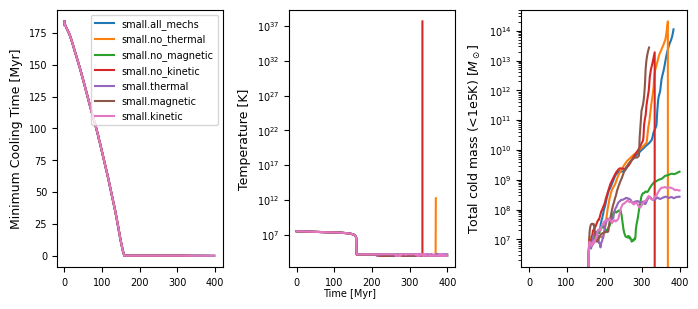

In [28]:
    
def add_minimum_temperature_to_ax(fig,ax,all_field_stats,label):
    """
    Adds the minimum temperature vs time to an axis
    from the all_field_stats object
    """
    ax.plot(all_field_stats["times"].in_units("Myr"),
            all_field_stats["temperature"]["min"].in_units("K"),
            label=label)

def add_minimum_cooling_time_to_ax(fig,ax,all_field_stats,label):
    """
    Adds the minimum cooling time vs time to an axis
    from the all_field_stats object
    """
    ax.plot(all_field_stats["times"].in_units("Myr")[:-2],
            all_field_stats["cooling_time"]["min"].in_units("Myr")[:-2],
            label=label)
    
def add_cold_mass_1e5K_to_ax(fig,ax,all_field_stats,label):
    """
    Adds the mass of gas under 1e5 K vs time to an axis
    from the all_field_stats object
    """
    ax.plot(all_field_stats["times"].in_units("Myr"),
            all_field_stats[f"cell_cold_mass_t<=1e5K"]["total"].in_units("msun"),
            label=label) 

        
#fig,axes = plt.subplots(nrows=4,ncols=4,figsize=(8,10),sharex="all",sharey="all")
        
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(7,3),sharex="all",sharey="none")

ax = axes[0]
plot_ax_suite(fig,ax,sim_names,sim_dirs,sim_labels,add_minimum_cooling_time_to_ax)
ax.set_ylabel("Minimum Cooling Time [Myr]")

ax = axes[1]
plot_ax_suite(fig,ax,sim_names,sim_dirs,sim_labels,add_minimum_temperature_to_ax)
ax.set_ylabel("Temperature [K]")
ax.set_yscale("log")

ax = axes[2]
plot_ax_suite(fig,ax,sim_names,sim_dirs,sim_labels,add_cold_mass_1e5K_to_ax)
ax.set_ylabel("Total cold mass (<1e5K) [$M_\\odot$]")
ax.set_yscale("log")

axes[0].legend()

fig.tight_layout(rect=[0.000,0.005,1.0,1.0])

fig.text(0.5, 0.0005, "Time [Myr]", ha='center', va='bottom')
#fig.text(0.0005, 0.5, "Minimum Cooling Time [Myr]", ha='left', va='center',rotation=90)

#fig.text(0.0005, 0.5, 'Energy [E]', ha='left', va='center', rotation='vertical')

#plt.savefig(f"{fig_dir}/cold_masses.pdf",bbox_inches="tight",padding=0)
